In [1]:
knitr::opts_chunk$set(echo = TRUE)

In [2]:
install.packages("feather")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



## load libraries

In [3]:
library(tidyverse)
library(feather)
library(ggplot2)
library(reticulate)

Warning message:
“Your system is mis-configured: ‘/etc/localtime’ is not a symlink”
Warning message:
“It is strongly recommended to set envionment variable TZ to ‘Etc/UCT’ (or equivalent)”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## read in data

In [4]:
setwd("/home/ec2-user/SageMaker/coles")

test              <- read_csv("data/test.csv")
transactions      <- read_csv("data/transactions.csv")
stores            <- read_csv("data/stores.csv")
sample_submission <- read_csv("data/sample_submission.csv")

Rows: 3370464 Columns: 5

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (3): id, store_nbr, item_nbr
lgl  (1): onpromotion
date (1): date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 83488 Columns: 3

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (2): store_nbr, transactions
date (1): date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 54 Columns: 5

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): city, state, type
dbl (2): store_nbr, cluster


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this messa

In [5]:
train <- read_csv("data/train.csv")
#write_feather(train, "data/train.feather")
#train <- read_feather("data/train.feather")

Rows: 125497040 Columns: 6

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (4): id, store_nbr, item_nbr, unit_sales
lgl  (1): onpromotion
date (1): date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



## quick look at the data - to understand problem and domain

In [6]:
print("train")
glimpse(train)
print("test")
glimpse(test)
print("transactions")
glimpse(transactions)
print("stores")
glimpse(stores)
print("sample_submission")
glimpse(sample_submission)

[1] "train"
Rows: 125,497,040
Columns: 6
$ id          <dbl> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, …
$ date        <date> 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-0…
$ store_nbr   <dbl> 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25…
$ item_nbr    <dbl> 103665, 105574, 105575, 108079, 108701, 108786, 108797, 10…
$ unit_sales  <dbl> 7, 1, 2, 1, 1, 3, 1, 1, 13, 3, 1, 1, 1, 1, 5, 1, 6, 10, 5,…
$ onpromotion <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA…
[1] "test"
Rows: 3,370,464
Columns: 5
$ id          <dbl> 125497040, 125497041, 125497042, 125497043, 125497044, 125…
$ date        <date> 2017-08-16, 2017-08-16, 2017-08-16, 2017-08-16, 2017-08-1…
$ store_nbr   <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ item_nbr    <dbl> 96995, 99197, 103501, 103520, 103665, 105574, 105575, 1055…
$ onpromotion <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FA…
[1] "transactions"
Rows: 83,488
Columns: 

## initial understanding & thoughts
- read competition description
- briefly looked at some shared EDA & modeling notebooks on kaggle

The challenge is to estimate total unit sales by item, store, and date, and the evaluation metric is the difference in log values such that relevative differences are weighted more. An additional weighting is also given to perishable items 

### notes
onpromotion is only partially complete and in store placement is not known 

id is unique row corresponding to date, store, item

### geography 

stores data provides type, cluster, city and state
- rather than a simple time series model of one item over time, the exercise is to make a forecast of items by store and hence geography
- most time models do not account for geographic structure
- interested in evaluating the AWS deepAR model which does account for the geographic structure and the relationship between times series for the same item

### holiday events
holidays may impact sales positively or negatively by locale

### items
items data contains categorical information relating to family, class and perishable status


## descriptive stats

In [7]:
#transactions per day by store may be useful?
min(test$date)
max(test$date)
max(test$date) -  min(test$date) + 1

min(train$date)
max(train$date)

max(train$date) - min(train$date) + 1

[1] "2017-08-16"

[1] "2017-08-31"

Time difference of 16 days

[1] "2013-01-01"

[1] "2017-08-15"

Time difference of 1688 days

In [8]:
fig <- function(width, heigth){
 options(repr.plot.width = width, repr.plot.height = heigth)
 }

### transaction time series

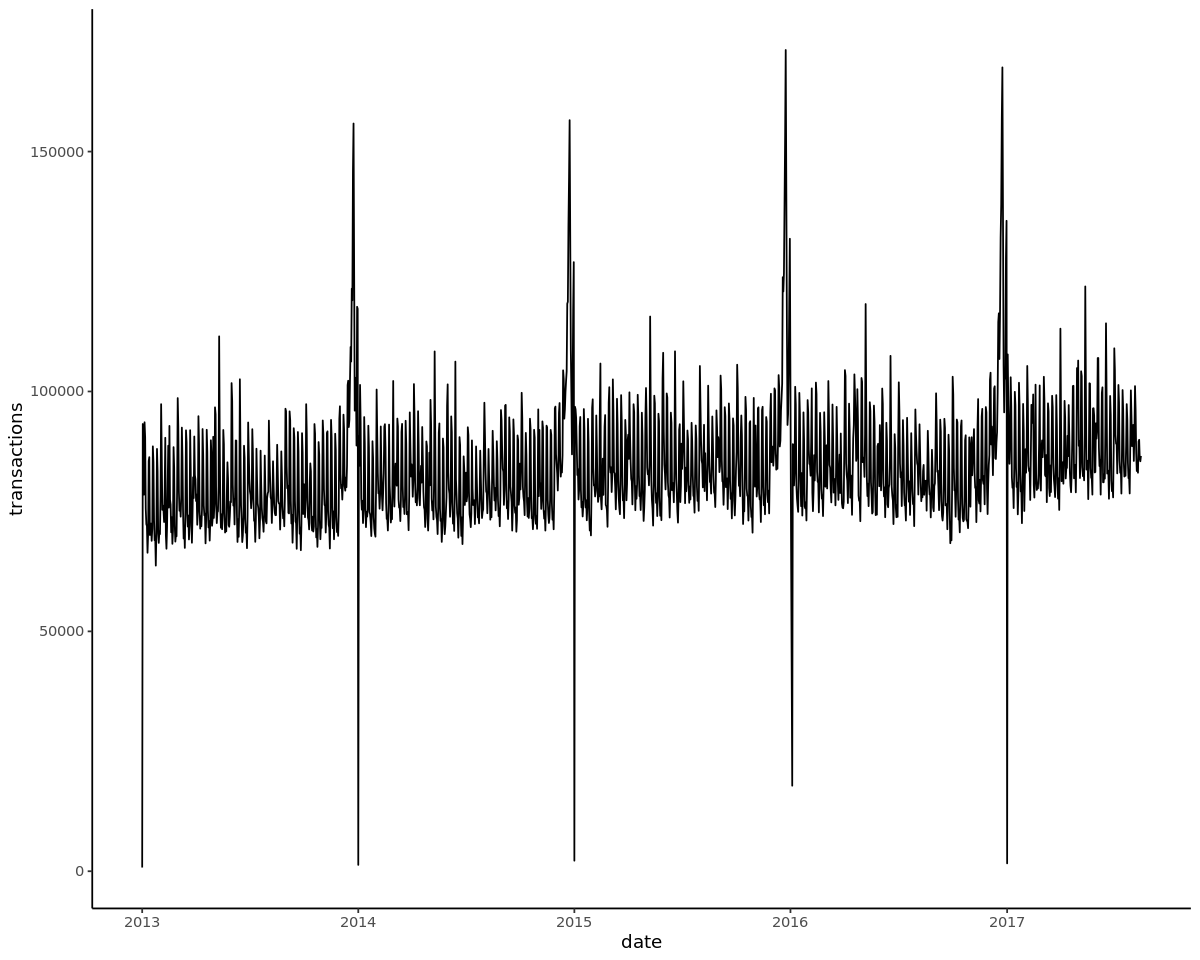

In [30]:
fig(10, 8)

transactions %>% group_by(date) %>% 
 summarise(transactions=sum(transactions)) %>%
  ggplot(.) + geom_line(aes(x=date,y=transactions)) + theme_classic()

`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.



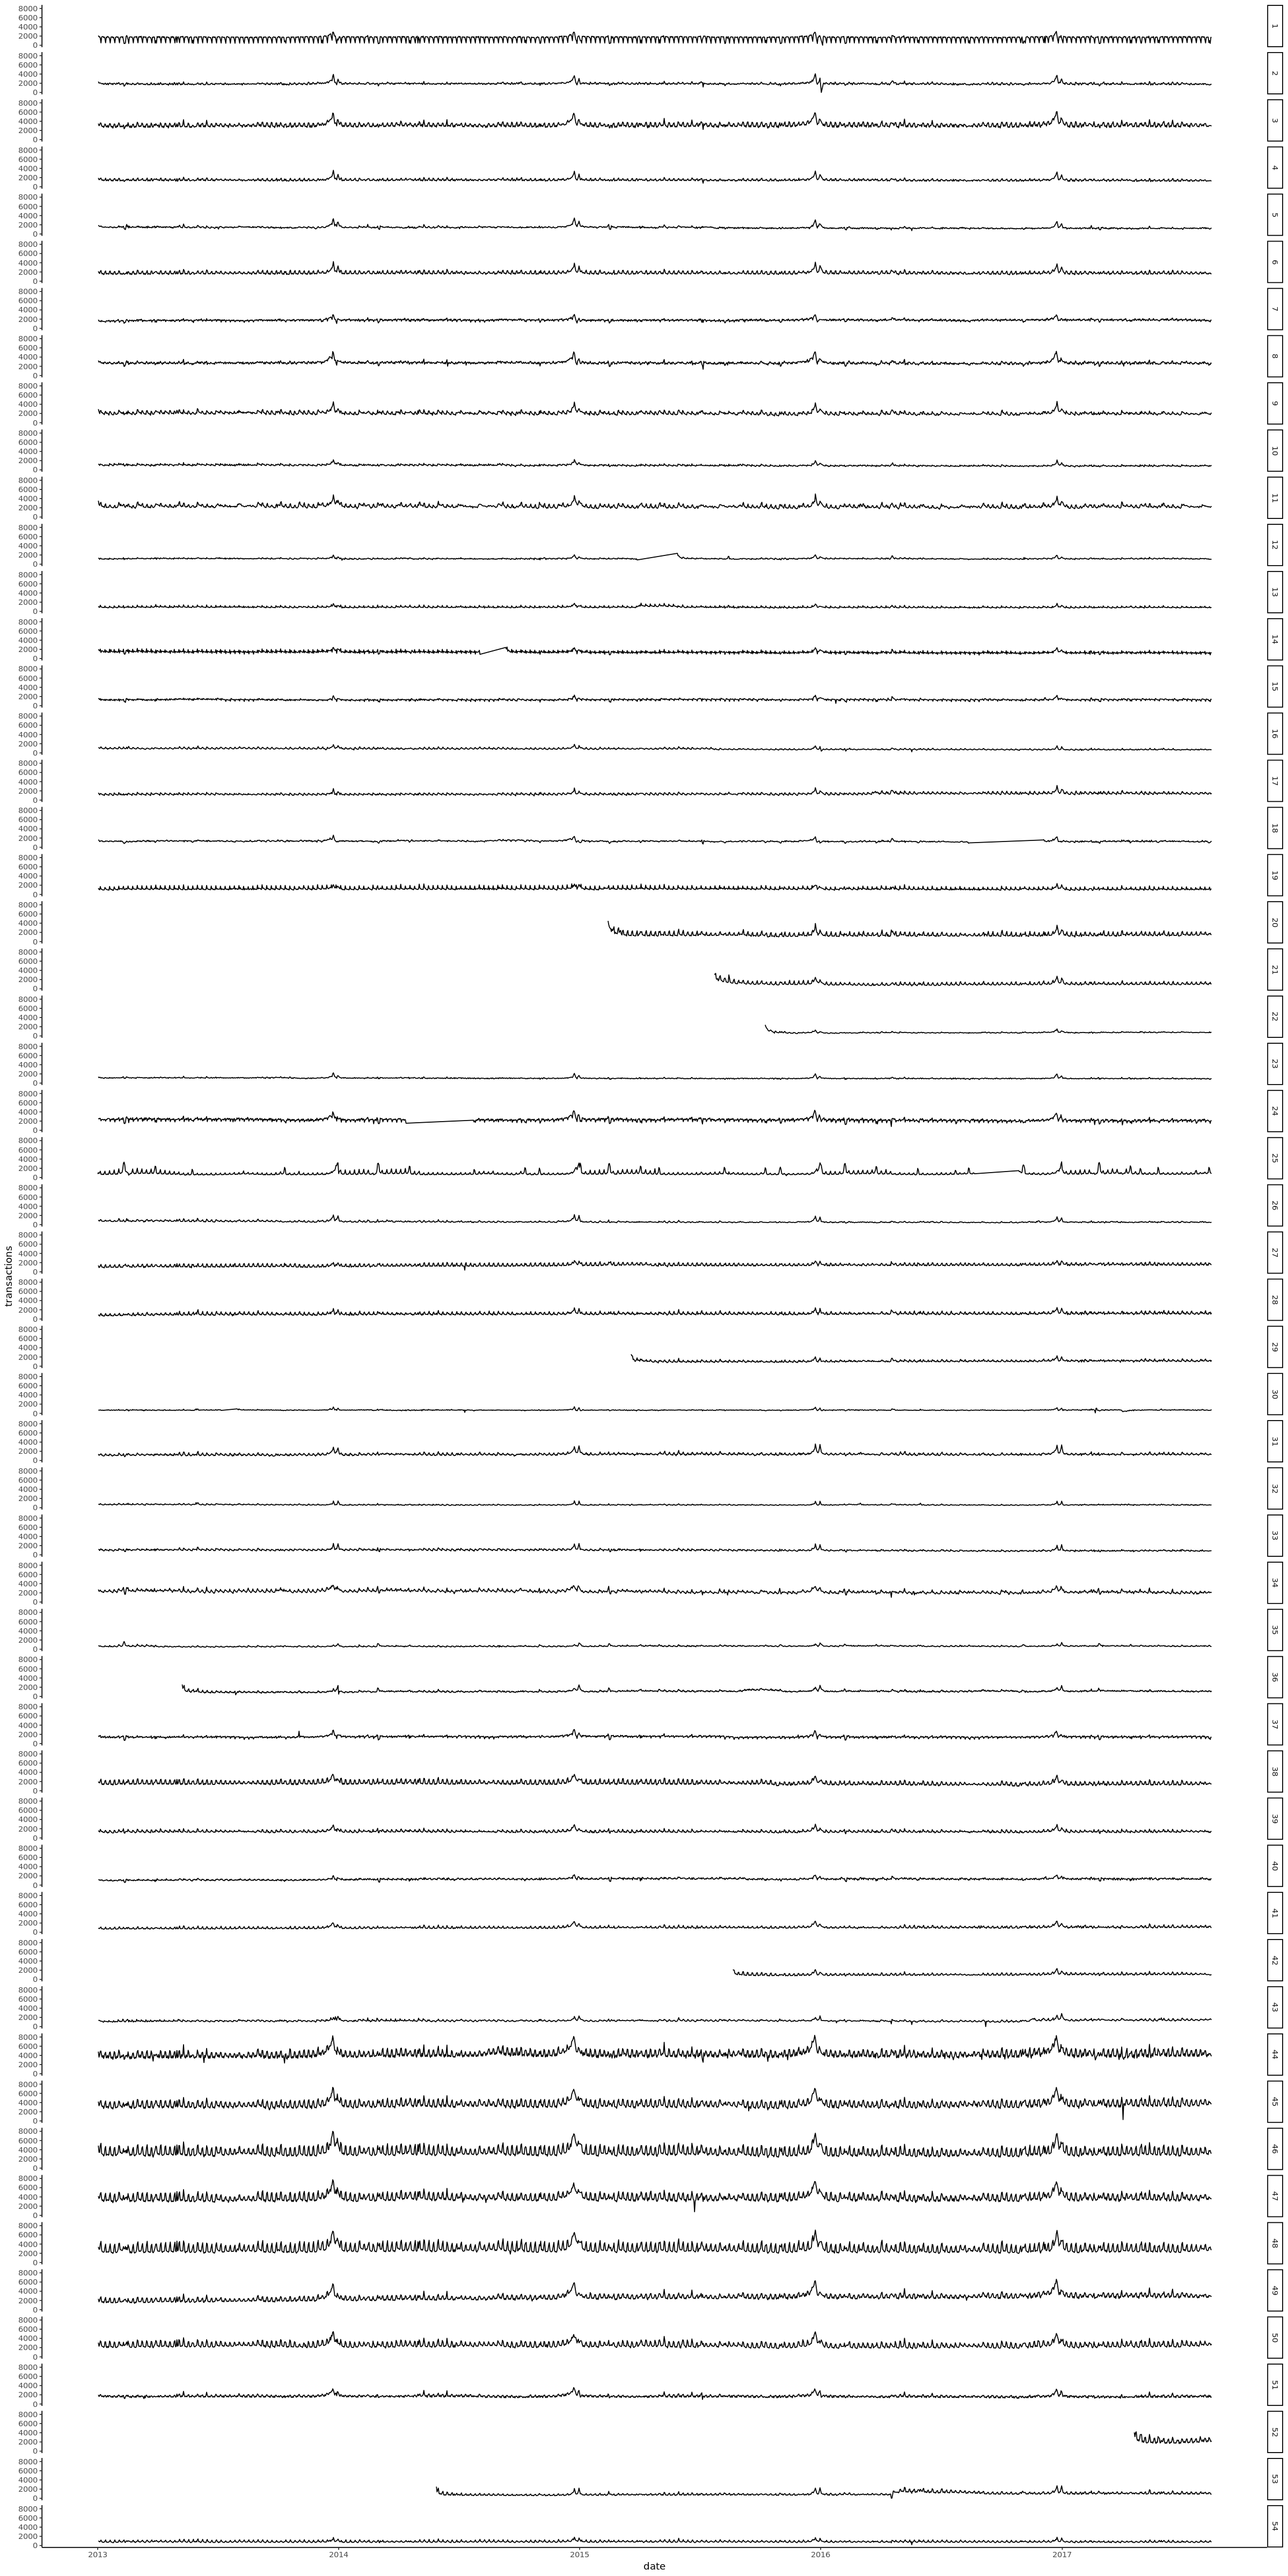

In [10]:
fig(20, 40)
transactions %>% group_by(date, store_nbr) %>% 
 summarise(transactions=sum(transactions)) %>% 
  ggplot(.) + geom_line(aes(x=date, y=transactions)) + theme_classic() + facet_grid(store_nbr ~ .)

### desc stores

In [11]:
print(paste("number of stores:", length(unique(stores$store_nbr))))
print(paste("no of items in train dataset:", length(unique(train$item_nbr))))
print(paste("no of items in test dataset:", length(unique(test$item_nbr))))

[1] "number of stores: 54"
[1] "no of items in train dataset: 4036"
[1] "no of items in test dataset: 3901"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



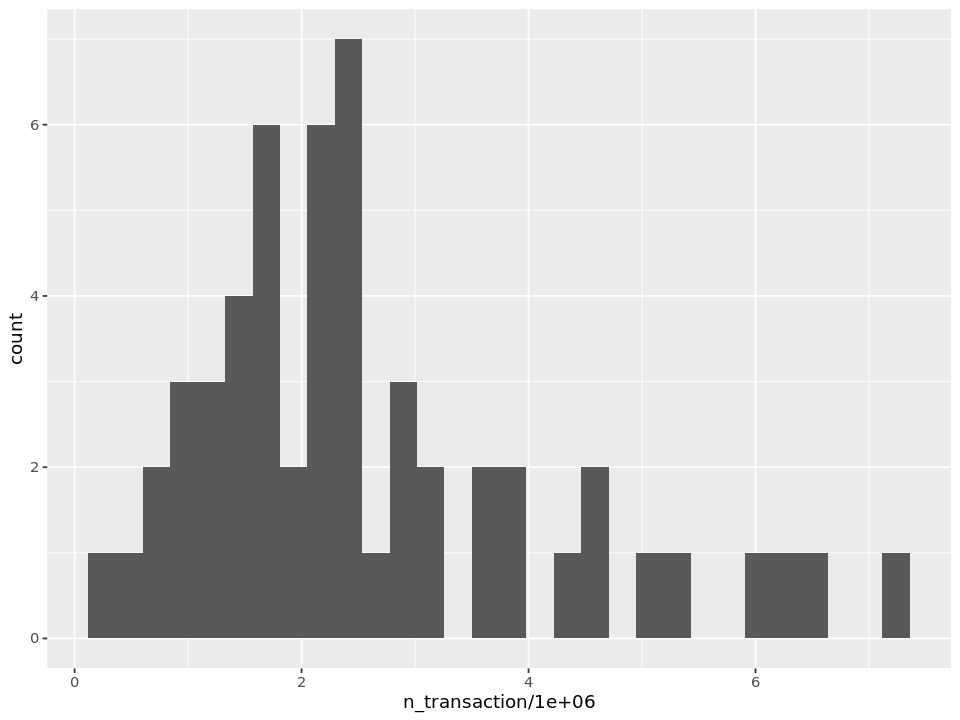

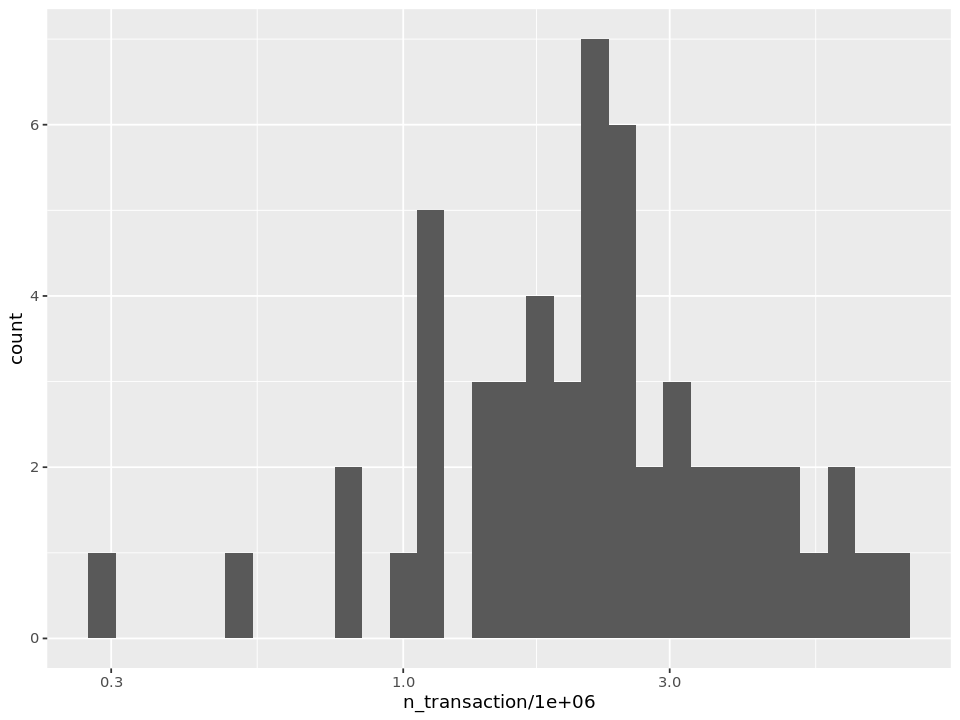

In [12]:
fig(8, 6)

store_df <- transactions %>% group_by(store_nbr) %>% summarise(n_transaction = sum(transactions)) %>% data.frame() %>% arrange(n_transaction)
store_df %>% ggplot(.) + geom_histogram(aes(n_transaction/1000000))
store_df %>% ggplot(.) + geom_histogram(aes(n_transaction/1000000)) + scale_x_log10()

In [13]:
store_items_df <- train %>% group_by(store_nbr) %>% 
                    summarise(n_items=length(unique(item_nbr))) 

In [14]:
store_items_df <- store_items_df %>% mutate(n_item_cat = case_when(
                            n_items < 3000 ~ 1,
                            n_items >= 3000 & n_items < 3400 ~ 2,
                            n_items >= 3400 ~ 3))

In [15]:
store_items_df %>% head()

store_nbr n_items n_item_cat
1 1         3567    3         
2 2         3594    3         
3 3         3671    3         
4 4         3548    3         
5 5         3528    3         
6 6         3597    3

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



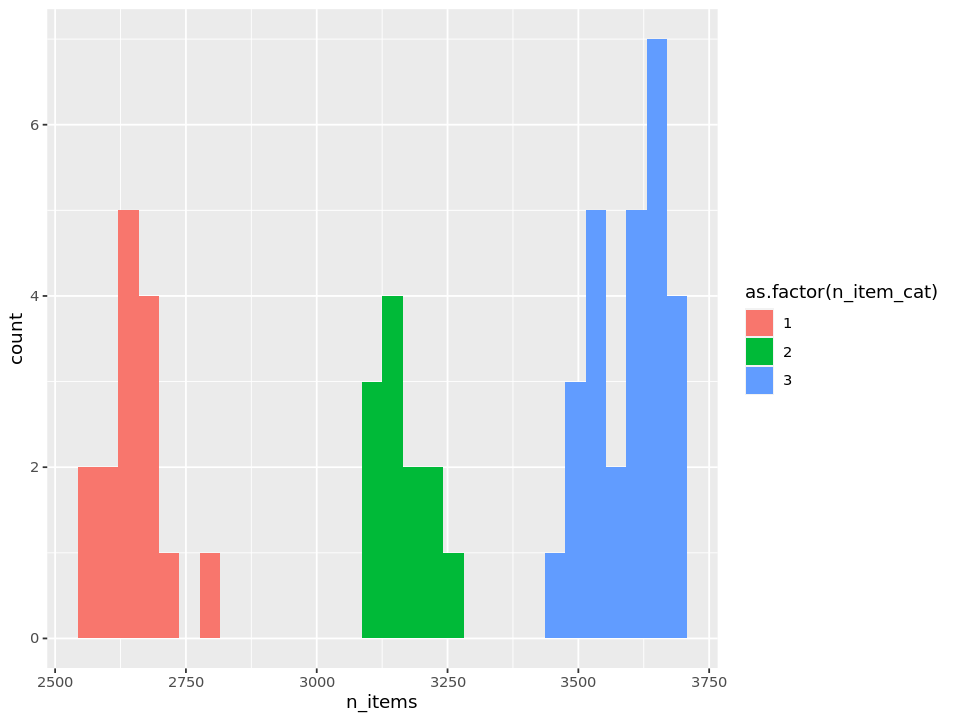

In [16]:
fig(8, 6)
store_items_df %>% ggplot(.) + geom_histogram(aes(n_items, group=n_item_cat, fill=as.factor(n_item_cat)))

In [17]:
store_items_df %>% data.frame() %>% arrange(-n_items) %>% head()

store_nbr n_items n_item_cat
1 47        3680    3         
2 45        3676    3         
3  3        3671    3         
4 44        3671    3         
5  8        3667    3         
6 49        3663    3

### stores & geography

In [18]:
head(stores)
table(stores$type)
table(stores$cluster)
table(stores$state) %>% data.frame() %>% arrange(-Freq) %>% t()
table(stores$city) %>% data.frame() %>% arrange(-Freq) %>% t()

store_nbr city          state                          type cluster
1 1         Quito         Pichincha                      D    13     
2 2         Quito         Pichincha                      D    13     
3 3         Quito         Pichincha                      D     8     
4 4         Quito         Pichincha                      D     9     
5 5         Santo Domingo Santo Domingo de los Tsachilas D     4     
6 6         Quito         Pichincha                      D    13


 A  B  C  D  E 
 9  8 15 18  4 


 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 
 3  2  7  3  1  6  2  3  2  6  3  1  4  4  5  1  1 

[,1]      [,2]   [,3]  [,4]   [,5]                           [,6]    
Var1 Pichincha Guayas Azuay Manabi Santo Domingo de los Tsachilas Cotopaxi
Freq 19        11      3     3      3                              2      
     [,7]   [,8]     [,9]       [,10]   [,11]      [,12]      [,13]    [,14]
Var1 El Oro Los Rios Tungurahua Bolivar Chimborazo Esmeraldas Imbabura Loja 
Freq  2      2        2          1       1          1          1        1   
     [,15]   [,16]      
Var1 Pastaza Santa Elena
Freq  1       1

[,1]  [,2]      [,3]   [,4]          [,5]   [,6]      [,7]    [,8] 
Var1 Quito Guayaquil Cuenca Santo Domingo Ambato Latacunga Machala Manta
Freq 18     8         3      3             2      2         2       2   
     [,9]     [,10]   [,11] [,12]      [,13]    [,14]  [,15]    [,16] [,17] 
Var1 Babahoyo Cayambe ⋯     Esmeraldas Guaranda Ibarra Libertad Loja  Playas
Freq  1        1      ⋯      1          1        1      1        1     1    
     [,18] [,19]   [,20]    [,21]  
Var1 Puyo  Quevedo Riobamba Salinas
Freq  1     1       1        1

In [20]:
m <- stores %>% left_join(store_items_df, by=c("store_nbr"="store_nbr"))

In [21]:
print("n_item_cat and type")
table(m$n_item_cat, m$type)
print("state and type")
table(m$state, m$type)
print("state and n_item_cat")
table(m$state, m$n_item_cat)

[1] "n_item_cat and type"


   
     A  B  C  D  E
  1  0  0 15  0  0
  2  0  8  0  0  4
  3  9  0  0 18  0

[1] "state and type"


                                
                                 A B C D E
  Azuay                          0 1 0 2 0
  Bolivar                        0 0 1 0 0
  Chimborazo                     0 0 1 0 0
  Cotopaxi                       0 0 2 0 0
  El Oro                         0 0 1 1 0
  Esmeraldas                     0 0 0 0 1
  Guayas                         1 1 3 3 3
  Imbabura                       0 0 1 0 0
  Loja                           0 0 0 1 0
  Los Rios                       0 1 1 0 0
  Manabi                         1 0 1 1 0
  Pastaza                        0 0 1 0 0
  Pichincha                      6 4 2 7 0
  Santa Elena                    0 0 0 1 0
  Santo Domingo de los Tsachilas 0 1 1 1 0
  Tungurahua                     1 0 0 1 0

[1] "state and n_item_cat"


                                
                                  1  2  3
  Azuay                           0  1  2
  Bolivar                         1  0  0
  Chimborazo                      1  0  0
  Cotopaxi                        2  0  0
  El Oro                          1  0  1
  Esmeraldas                      0  1  0
  Guayas                          3  4  4
  Imbabura                        1  0  0
  Loja                            0  0  1
  Los Rios                        1  1  0
  Manabi                          1  0  2
  Pastaza                         1  0  0
  Pichincha                       2  4 13
  Santa Elena                     0  0  1
  Santo Domingo de los Tsachilas  1  1  1
  Tungurahua                      0  0  2

In [22]:
print("city and type")
table(m$city, m$type)
print("city and n_item_cat")
table(m$city, m$n_item_cat)

[1] "city and type"


               
                A B C D E
  Ambato        1 0 0 1 0
  Babahoyo      0 1 0 0 0
  Cayambe       0 1 0 0 0
  Cuenca        0 1 0 2 0
  Daule         0 0 0 1 0
  El Carmen     0 0 1 0 0
  Esmeraldas    0 0 0 0 1
  Guaranda      0 0 1 0 0
  Guayaquil     1 1 2 2 2
  Ibarra        0 0 1 0 0
  Latacunga     0 0 2 0 0
  Libertad      0 0 0 0 1
  Loja          0 0 0 1 0
  Machala       0 0 1 1 0
  Manta         1 0 0 1 0
  Playas        0 0 1 0 0
  Puyo          0 0 1 0 0
  Quevedo       0 0 1 0 0
  Quito         6 3 2 7 0
  Riobamba      0 0 1 0 0
  Salinas       0 0 0 1 0
  Santo Domingo 0 1 1 1 0

[1] "city and n_item_cat"


               
                 1  2  3
  Ambato         0  0  2
  Babahoyo       0  1  0
  Cayambe        0  1  0
  Cuenca         0  1  2
  Daule          0  0  1
  El Carmen      1  0  0
  Esmeraldas     0  1  0
  Guaranda       1  0  0
  Guayaquil      2  3  3
  Ibarra         1  0  0
  Latacunga      2  0  0
  Libertad       0  1  0
  Loja           0  0  1
  Machala        1  0  1
  Manta          0  0  2
  Playas         1  0  0
  Puyo           1  0  0
  Quevedo        1  0  0
  Quito          2  3 13
  Riobamba       1  0  0
  Salinas        0  0  1
  Santo Domingo  1  1  1

In [23]:
table(m$city, m$state) 

               
                Azuay Bolivar Chimborazo Cotopaxi El Oro Esmeraldas Guayas
  Ambato            0       0          0        0      0          0      0
  Babahoyo          0       0          0        0      0          0      0
  Cayambe           0       0          0        0      0          0      0
  Cuenca            3       0          0        0      0          0      0
  Daule             0       0          0        0      0          0      1
  El Carmen         0       0          0        0      0          0      0
  Esmeraldas        0       0          0        0      0          1      0
  Guaranda          0       1          0        0      0          0      0
  Guayaquil         0       0          0        0      0          0      8
  Ibarra            0       0          0        0      0          0      0
  Latacunga         0       0          0        2      0          0      0
  Libertad          0       0          0        0      0          0      1
  Loja   

In [24]:
m %>% head()

store_nbr city          state                          type cluster n_items
1 1         Quito         Pichincha                      D    13      3567   
2 2         Quito         Pichincha                      D    13      3594   
3 3         Quito         Pichincha                      D     8      3671   
4 4         Quito         Pichincha                      D     9      3548   
5 5         Santo Domingo Santo Domingo de los Tsachilas D     4      3528   
6 6         Quito         Pichincha                      D    13      3597   
  n_item_cat
1 3         
2 3         
3 3         
4 3         
5 3         
6 3

### transaction times series by geography

In [25]:
storelist <- sample(unique(stores$store_nbr), 10)
storelist

[1] 40  3 47 38 26 22 31 43 19 29

`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.



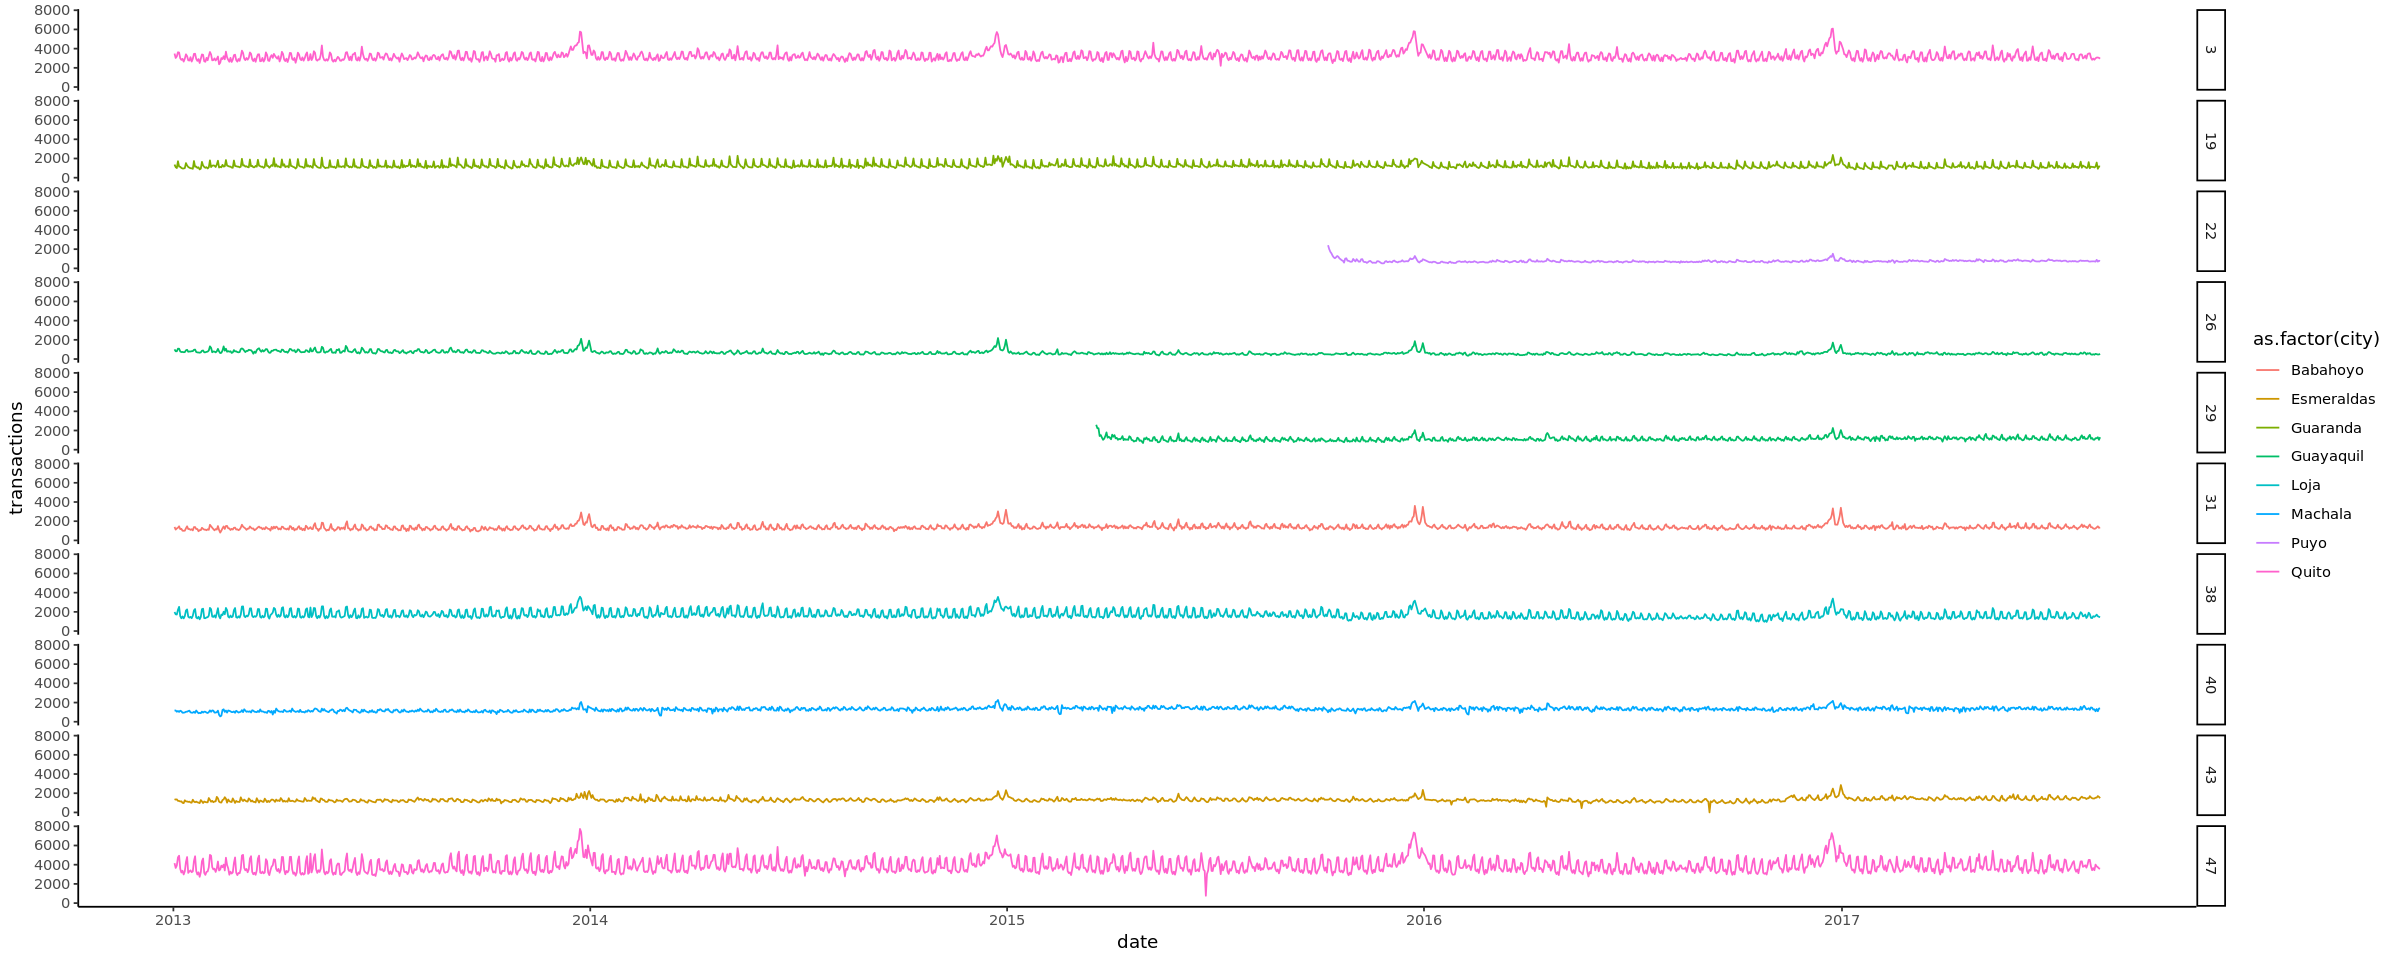

In [26]:
fig(20, 8)
transactions %>% group_by(date, store_nbr) %>% 
 summarise(transactions=sum(transactions)) %>% left_join(., m, by=("store_nbr"="store_nbr")) %>% filter(store_nbr %in% storelist) %>%
  ggplot(.) + geom_line(aes(x=date, y=transactions, colour=as.factor(city))) + theme_classic() + facet_grid(store_nbr ~ .)

`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.



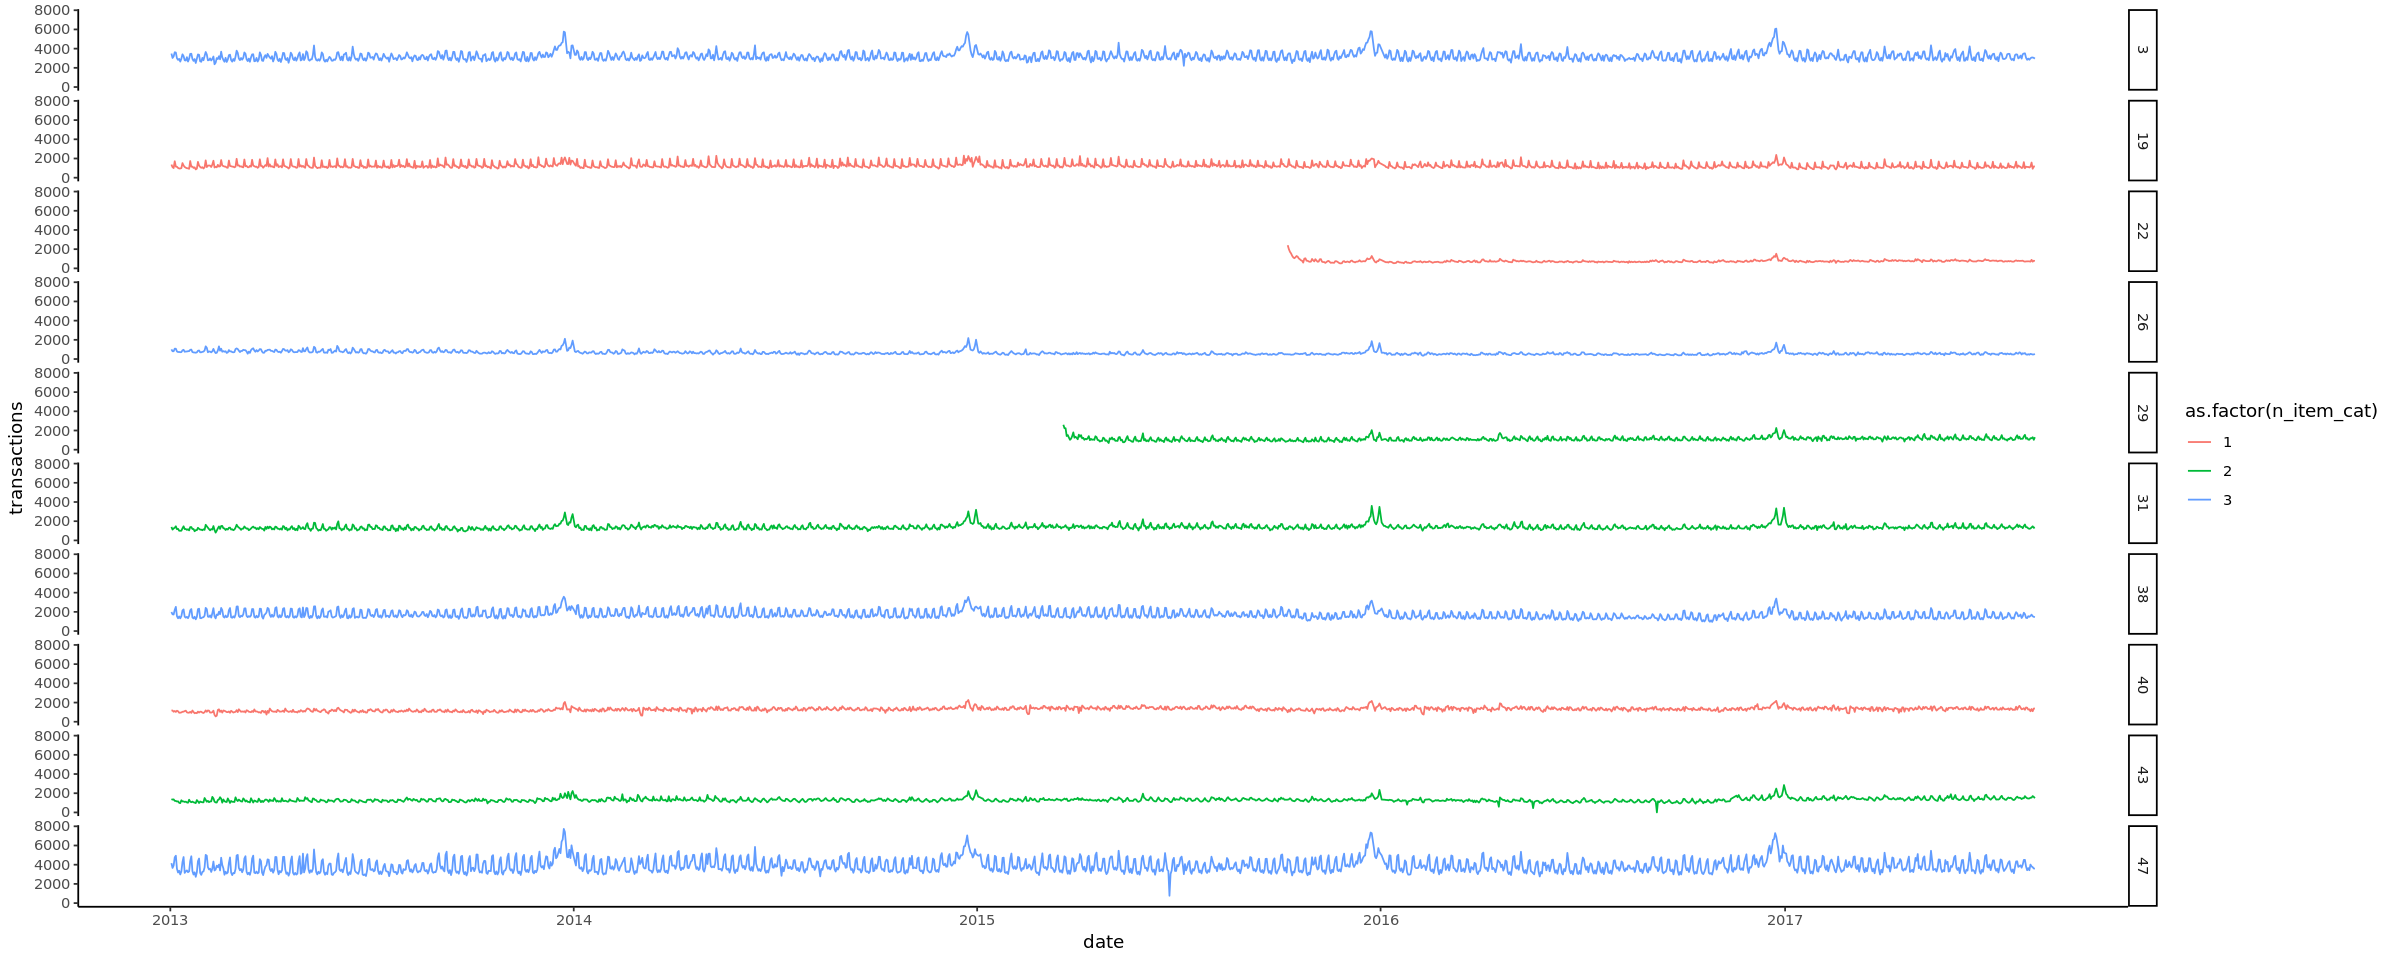

In [27]:
fig(20, 8)
transactions %>% group_by(date, store_nbr) %>% 
 summarise(transactions=sum(transactions)) %>% left_join(., m, by=("store_nbr"="store_nbr")) %>% filter(store_nbr %in% storelist) %>%
  ggplot(.) + geom_line(aes(x=date, y=transactions, colour=as.factor(n_item_cat))) + theme_classic() + facet_grid(store_nbr ~ .)

- some stores were opened later
- stores with more items (e.g. n_item_cat 3) had more transactions per day on average
- stores with a greater number of transactions appeared to have a more predictable pattern in trend